In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sortedcontainers import SortedList
from sklearn.model_selection import train_test_split
import math

In [2]:
df = pd.read_csv('../dataset/rating_final.csv')
df = shuffle(df)

df_train, df_test = train_test_split(df)

In [3]:
user_to_movie = {}
movie_to_user = {}
movie_user_rating = {}
movie_user_rating_train = {}
movie_user_rating_test = {}

bias_movie = {}
bias_user = {}

for row in df.values:
    movie_id, user_id, rate = row
    if movie_id not in user_to_movie:
        user_to_movie[user_id] = [movie_id]
    else:
        user_to_movie[user_id].append(movie_id)
    
    if movie_id not in movie_to_user:
        movie_to_user[movie_id] = [user_id]
    else:
        movie_to_user[movie_id].append(user_id)

    movie_user_rating[(movie_id, user_id)] = rate

average = np.mean(list(movie_user_rating.values()))

for user_id in user_to_movie:
    rates = []
    for movie_id in user_to_movie[user_id]:
        rates.append(movie_user_rating[(movie_id, user_id)] - average)
    bias_user[user_id] = np.mean(rates)

for movie_id in movie_to_user:
    rates = []
    for user_id in movie_to_user[movie_id]:
        rates.append(movie_user_rating[(movie_id, user_id)] - average)
    bias_movie[movie_id] = np.mean(rates)

for row in df_train.values:
    movie_id, user_id, rate = row
    movie_user_rating_train[(movie_id, user_id)] = rate

for row in df_test.values:
    movie_id, user_id, rate = row
    movie_user_rating_test[(movie_id, user_id)] = rate

In [4]:
print(average)
print(bias_movie)
print(bias_user)

8.155672030712312
{'tt0107048': 0.14514097741776946, 'tt2701582': 0.38877241373213245, 'tt1646971': -0.01986956157650937, 'tt0078480': -0.27505187567355216, 'tt8579674': 0.16639881397433642, 'tt0082971': 0.5464556288621565, 'tt1049413': 0.03069160565132475, 'tt4633694': -0.2471613924144393, 'tt0081505': 0.08467504087120233, 'tt0808417': 0.009221586308964759, 'tt0031381': 0.20623273119244978, 'tt0108255': -1.5632669674211725, 'tt0088509': -0.9264037380293848, 'tt0773262': 0.43866759192919724, 'tt15679400': -2.081525689248897, 'tt12343534': 0.49873973399357063, 'tt0050825': -0.07270906774934875, 'tt0032551': 0.07627241373213242, 'tt0120382': 0.06971258467230335, 'tt0137523': 0.570814455774175, 'tt3521164': -0.3181085789356622, 'tt1641384': 0.3232012087243081, 'tt0104652': -0.2528148878551689, 'tt2356777': 0.26498014320073165, 'tt0017925': 0.2772046816164551, 'tt2013293': -0.4759251952692737, 'tt0114709': 0.15032796928768868, 'tt0043014': 0.3190754440351632, 'tt11358390': -1.4842434592837

In [5]:
number_of_movie = int(len(movie_to_user.keys()))
number_of_user = int(len(user_to_movie.keys()))

print(f'Number of movie: {number_of_movie}')
print(f'Number of user: {number_of_user}')

Number of movie: 490
Number of user: 1000


In [6]:
# latent dimensionality
k = 30
W = dict.fromkeys(user_to_movie.keys())
U = dict.fromkeys(movie_to_user.keys())

In [7]:
print(len(W), len(U))

1000 490


In [8]:
def evaluate():
    loss = 0
    for movie_id, user_id in movie_user_rating_test:
        rate = movie_user_rating_test[(movie_id, user_id)]
        error = rate - get_rating(user_id, movie_id)

        loss += error ** 2
    return (loss / len(movie_user_rating_test), math.sqrt(loss / len(movie_user_rating_test)))

def evaluate_with_bias():
    loss = 0
    for movie_id, user_id in movie_user_rating_test:
        rate = movie_user_rating_test[(movie_id, user_id)]
        error = rate - get_rating_with_bias(user_id, movie_id)

        loss += error ** 2
    return (loss / len(movie_user_rating_test), math.sqrt(loss / len(movie_user_rating_test)))

def get_rating(user_id, movie_id):
    return np.dot(W[user_id], U[movie_id])

def get_rating_with_bias(user_id, movie_id):
    return np.dot(W[user_id], U[movie_id]) + average + bias_movie[movie_id] + bias_user[user_id]

In [9]:
def dump():
    for user_id in W.keys():
        W[user_id] = np.random.randn(k)
    for movie_id in U.keys():
        U[movie_id] = np.random.randn(k)

def fit(epoch, learning_rate, weight, update_func, evaluate_func):
    losses_train = []
    losses_validation = []

    rmse_train = []
    rmse_validation = []

    dump()

    for i in range(0, epoch):
        loss = 0    
        
        for movie_id, user_id in movie_user_rating_train:
            loss += update_func((movie_id, user_id, learning_rate, weight))

        loss = loss / len(movie_user_rating_train)
        rmse = math.sqrt(loss)

        loss_test, rmse_test = evaluate_func()
        
        losses_train.append(loss)
        losses_validation.append(loss_test)

        rmse_train.append(rmse)
        rmse_validation.append(rmse_test)

        print(f'Epoch: {i + 1}/{epoch}')
        print('Loss: ' , loss, 'RMSE: ', rmse, 'Loss_Validation: ', loss_test, 'RMSE_Validation: ', rmse_test)

    x_axis = list(range(1, epoch + 1))
    fig, axis = plt.subplots(nrows = 1, ncols = 2)

    axis[0].plot(x_axis, losses_train, color = 'red', label = 'Loss Train')
    axis[0].set_xlabel('Epoch')
    axis[0].set_ylabel('Loss')

    axis[0].plot(x_axis, losses_validation, color = 'blue', label = 'Loss Test')
    axis[0].legend(loc = 'upper right')

    axis[1].plot(x_axis, rmse_train, color = 'red', label = 'RMSE Train')
    axis[1].set_xlabel('Epoch')
    axis[1].set_ylabel('RMSE')

    axis[1].plot(x_axis, rmse_validation, color = 'blue', label = 'RMSE Test')
    axis[1].legend(loc = 'upper right')
    plt.show()
    

In [10]:
def matrix_fact(args):
    movie_id, user_id, learning_rate, _ = args
    rate = movie_user_rating_train[(movie_id, user_id)]
    
    error = rate - np.dot(W[user_id], U[movie_id])
    
    saved_w = np.copy(W[user_id])
    saved_u = np.copy(U[movie_id])

    W[user_id] += 2 * learning_rate * error * saved_u
    U[movie_id] += 2 * learning_rate * error * saved_w

    return error ** 2

def matrix_fact_with_bias(args):
    global average

    movie_id, user_id, learning_rate, weight = args
    rate = movie_user_rating_train[(movie_id, user_id)]

    predict_rating = average + bias_movie[movie_id] + bias_user[user_id] + np.dot(W[user_id], U[movie_id])
    
    error = rate - predict_rating

    average = average + learning_rate * error

    bias_movie[movie_id] += learning_rate * (error - weight * bias_movie[movie_id])
    bias_user[user_id] += learning_rate * (error - weight * bias_user[user_id])
    
    saved_w = np.copy(W[user_id])
    saved_u = np.copy(U[movie_id])

    W[user_id] += learning_rate * (2 * error * saved_u - weight * saved_w)
    U[movie_id] += learning_rate * (2 * error * saved_w - weight * saved_u)

    return error ** 2

def get_top_n(user_id, get_rating_func, n = 10):
    recommend_list = SortedList()
    for movie_id in movie_to_user.keys():
        if (movie_id, user_id) not in movie_user_rating:
            rating = get_rating_func(user_id, movie_id)
            recommend_list.add((rating, movie_id))
            if len(recommend_list) > n:
                del recommend_list[0]
    return recommend_list

Epoch: 1/100
Loss:  34.0377177179147 RMSE:  5.834185265991705 Loss_Validation:  7.88031833628681 RMSE_Validation:  2.8071904702543446
Epoch: 2/100
Loss:  3.568340513388007 RMSE:  1.889005164997705 Loss_Validation:  5.187995191830173 RMSE_Validation:  2.2777171009214845
Epoch: 3/100
Loss:  2.0063634558575516 RMSE:  1.416461597028861 Loss_Validation:  4.774327728364471 RMSE_Validation:  2.1850235075084368
Epoch: 4/100
Loss:  1.6462966040478981 RMSE:  1.2830809031576684 Loss_Validation:  4.655212676814712 RMSE_Validation:  2.1575941872406665
Epoch: 5/100
Loss:  1.4465393856453026 RMSE:  1.2027216575938517 Loss_Validation:  4.633999504485114 RMSE_Validation:  2.1526726422020404
Epoch: 6/100
Loss:  1.2984549987071932 RMSE:  1.1394976957884528 Loss_Validation:  4.653611479501885 RMSE_Validation:  2.1572230945133803
Epoch: 7/100
Loss:  1.1769497188355964 RMSE:  1.0848731349036147 Loss_Validation:  4.690137766255802 RMSE_Validation:  2.1656725898103346
Epoch: 8/100
Loss:  1.0734487107505772 RM

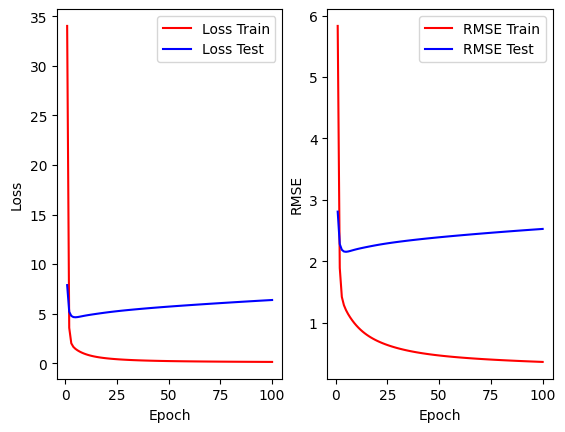

SortedList([(11.110835059684241, 'tt5555260'), (11.289553892428527, 'tt2049116'), (11.47928259911722, 'tt7908628'), (11.583609642486856, 'tt0268093'), (11.614753428908546, 'tt4873118'), (11.655586804831037, 'tt1641384'), (11.74235698207744, 'tt0187664'), (12.348830855223488, 'tt1533395'), (12.383277029945289, 'tt0303461'), (12.421361003862911, 'tt1910272')])

In [11]:
fit(100, 0.01, 0.2, matrix_fact, evaluate)

get_top_n('ur156820301', get_rating)

Epoch: 1/100
Loss:  11.157957979445953 RMSE:  3.34035297228391 Loss_Validation:  4.339068387843306 RMSE_Validation:  2.0830430595269283
Epoch: 2/100
Loss:  2.1043560239831867 RMSE:  1.450639867087344 Loss_Validation:  3.259961795850146 RMSE_Validation:  1.8055364288349725
Epoch: 3/100
Loss:  1.5017753817866666 RMSE:  1.225469453632634 Loss_Validation:  2.850997822824239 RMSE_Validation:  1.6884898053658006
Epoch: 4/100
Loss:  1.288104913418089 RMSE:  1.1349470971891549 Loss_Validation:  2.6327596200347854 RMSE_Validation:  1.6225780782553378
Epoch: 5/100
Loss:  1.165206532876116 RMSE:  1.0794473275135366 Loss_Validation:  2.4984601273551474 RMSE_Validation:  1.580651804590482
Epoch: 6/100
Loss:  1.0770130698378102 RMSE:  1.0377924020910012 Loss_Validation:  2.409248015412709 RMSE_Validation:  1.5521752528025659
Epoch: 7/100
Loss:  1.0058717520442744 RMSE:  1.002931578944583 Loss_Validation:  2.3470832451798134 RMSE_Validation:  1.532019335772174
Epoch: 8/100
Loss:  0.9450849408644207 R

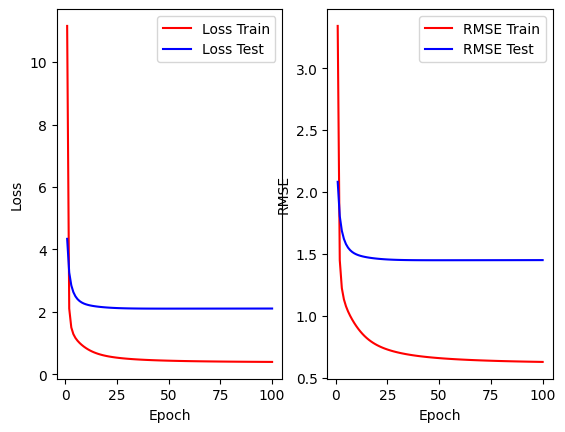

SortedList([(8.96213093012361, 'tt2560140'), (8.962181309964004, 'tt1606375'), (8.994899427967793, 'tt3398228'), (9.008371850499902, 'tt7678620'), (9.008877728957618, 'tt1355642'), (9.012023593183372, 'tt9735318'), (9.021284197810765, 'tt0109830'), (9.06213246846158, 'tt0071562'), (9.13374740555708, 'tt20869502'), (9.442745705809493, 'tt0268093')])

In [12]:
fit(100, 0.01, 0.2, matrix_fact_with_bias, evaluate_with_bias)

get_top_n('ur156820301', get_rating_with_bias)